In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight

# Cargar el conjunto de datos (puedes cambiarlo por CIFAR-10 u otro)
from tensorflow.keras.datasets import cifar10

# Cargar y dividir en entrenamiento y prueba
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Ver los datos y las clases
print(f'Número total de imágenes: {X_train.shape[0]}')
print(f'Número total de categorías: {np.unique(y_train).size}')

# Para propósitos de ilustración, trabajaremos solo con dos clases
clase_1 = 1  # Clase de ejemplo, puedes cambiar
clase_2 = 3  # Otra clase de ejemplo, puedes cambiar

# Filtrar las imágenes de estas dos clases
idx = np.where((y_train == clase_1) | (y_train == clase_2))[0]
X_train_filtered = X_train[idx]
y_train_filtered = y_train[idx].flatten()  # Aplana el array de etiquetas

# Ahora simulamos el sesgo al reducir el número de imágenes de una clase
num_class_1 = np.sum(y_train_filtered == clase_1)
num_class_2 = np.sum(y_train_filtered == clase_2)

# Reducimos el número de imágenes de la clase 2 para simular el sesgo
num_class_2_reduced = int(0.2 * num_class_2)  # Mantener solo el 20% de las imágenes de la clase 2
idx_class_2 = np.where(y_train_filtered == clase_2)[0][:num_class_2_reduced]

# Creamos un nuevo conjunto de datos con la clase 2 reducida
X_train_balanced = np.concatenate([X_train_filtered[y_train_filtered == clase_1],
                                   X_train_filtered[idx_class_2]], axis=0)
y_train_balanced = np.concatenate([y_train_filtered[y_train_filtered == clase_1],
                                   y_train_filtered[idx_class_2]], axis=0)

# Comprobar la distribución de clases después de simular el sesgo
print(f'Distribución de clases después del sesgo: {np.bincount(y_train_balanced)}')

Número total de imágenes: 50000
Número total de categorías: 10
Distribución de clases después del sesgo: [   0 5000    0 1000]


In [3]:
# Crear un modelo CNN básico
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Solo 2 clases, salida con sigmoide
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Como es clasificación binaria
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,985 (476.50 KB)

 Trainable params: 121,985 (476.50 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Entrenamiento del modelo con los datos desequilibrados
history = model.fit(X_train_balanced, y_train_balanced,
                    epochs=10, batch_size=64,
                    validation_data=(X_test, y_test))

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc:.2f}')

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.7835 - loss: -2814375.0000 - val_accuracy: 0.1000 - val_loss: -1814252288.0000
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8390 - loss: -1418893312.0000 - val_accuracy: 0.1000 - val_loss: -179224576000.0000
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.8346 - loss: -42555498496.0000 - val_accuracy: 0.1000 - val_loss: -2278599950336.0000
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.8311 - loss: -365585694720.0000 - val_accuracy: 0.1000 - val_loss: -12444079489024.0000
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8320 - loss: -1733930647552.0000 - val_accuracy: 0.1000 - val_loss: -44794608877568.0000
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.8279 - loss: -5736070905856.0000 - val_accuracy: 0.1000 - val_loss: -121273770311680.0000
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8397 - loss: -13

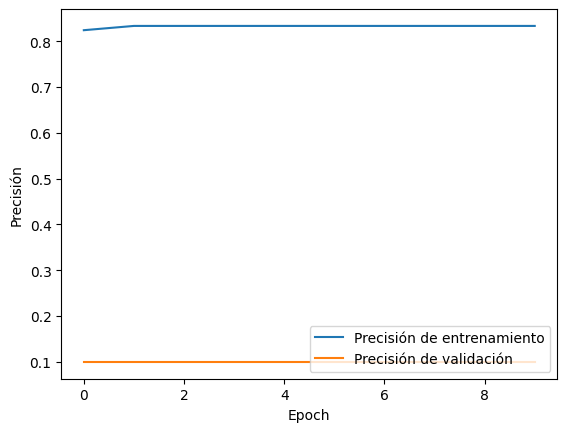

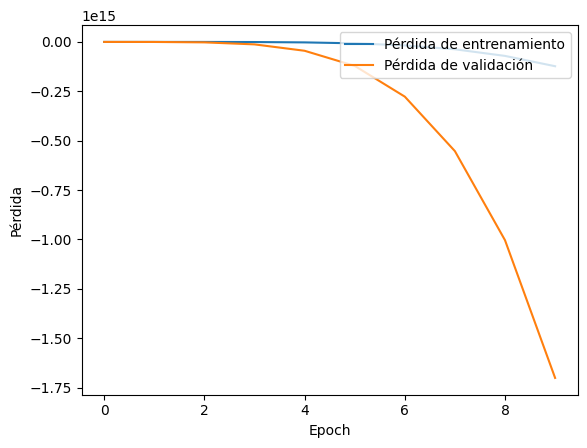

In [5]:
# Visualizar los resultados
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Epoch')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

# Curva de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


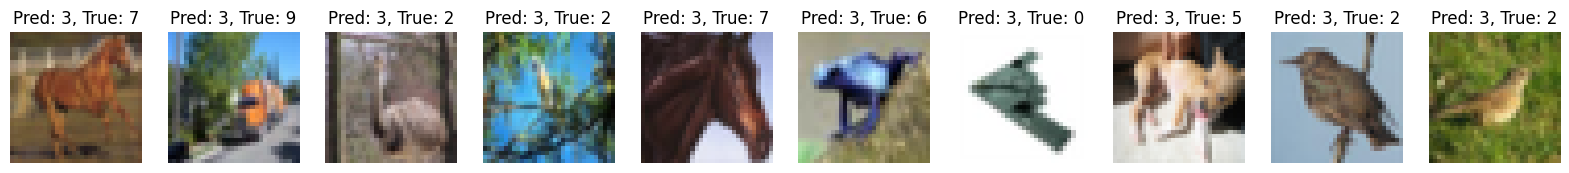

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Número de imágenes a mostrar
num_images = 10

# Seleccionar imágenes aleatorias del conjunto de prueba
random_indices = np.random.choice(X_test.shape[0], size=num_images, replace=False)
images = X_test[random_indices]
labels = y_test[random_indices]

# Obtener las predicciones del modelo
predictions = model.predict(images)

# Mostrar las imágenes con las predicciones
fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
    predicted_label = clase_1 if predictions[i][0] < 0.5 else clase_2  # Umbral de 0.5
    true_label = labels[i][0]
    ax.set_title(f'Pred: {predicted_label}, True: {true_label}')

plt.show()

In [7]:
categorias_cifar10 = [
    "Avión",
    "Automóvil",
    "Pájaro",
    "Gato",
    "Ciervo",
    "Perro",
    "Rana",
    "Caballo",
    "Barco",
    "Camión"
]